In [1]:
# Import all libraries

import os                          # for working with folders and file paths
import pandas as pd                # for reading and manipulating data tables
import numpy as np                 # for math and numerical operations
import matplotlib.pyplot as plt    # for creating charts
import seaborn as sns              # for nicer-looking charts

# scikit-learn: the machine learning library
from sklearn.model_selection import train_test_split        # splits data into train and test sets
from sklearn.pipeline import Pipeline                       # chains processing steps together
from sklearn.preprocessing import StandardScaler            # rescales number columns to the same range
from sklearn.linear_model import LogisticRegression         # the ML model we will use
from sklearn.metrics import (
    classification_report,      # shows precision, recall, f1-score per class
    roc_auc_score,              # overall performance score (0.5 = random, 1.0 = perfect)
    ConfusionMatrixDisplay,     # visual chart of correct vs incorrect predictions
)

# Display setting: show all columns when printing a dataframe
pd.set_option("display.max_columns", None)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load Files

HW1_FOLDER = "../MO-IT134 - Week 3 Homework Project Dataset Preprocessing and Feature Engineering BSIT-a3101 Miguel M."
CLEANED    = os.path.join(HW1_FOLDER, "cleaned_data")
RAW        = os.path.join(HW1_FOLDER, "raw_data")

# Cleaned files (output of HW1)
clean_transactions = pd.read_csv(os.path.join(CLEANED, "clean_transactions.csv"))
clean_customers    = pd.read_csv(os.path.join(CLEANED, "clean_customers.csv"))
clean_products     = pd.read_csv(os.path.join(CLEANED, "clean_products.csv"))

# Raw customers file — used to find the 10 non-purchaser companies
raw_customers = pd.read_csv(os.path.join(RAW, "customers_data.csv"))

print("Files loaded successfully:")
print(f"  clean_transactions : {len(clean_transactions):,} rows")
print(f"  clean_customers    : {len(clean_customers):,} rows")
print(f"  clean_products     : {len(clean_products):,} rows")
print(f"  raw_customers      : {len(raw_customers):,} rows")

Files loaded successfully:
  clean_transactions : 4,780 rows
  clean_customers    : 90 rows
  clean_products     : 18 rows
  raw_customers      : 100 rows


In [3]:
# Clean the product prices
# The Product_Price looks like: '?140,000'
# Step 1 → remove '?' (the incorrectly saved peso sign)
# Step 2 → remove ',' (thousands separator)
# Step 3 → convert from text to a proper decimal number (float)

clean_products["Product_Price_PHP"] = (
    clean_products["Product_Price"]
    .str.replace("?", "", regex=False)   # remove peso sign
    .str.replace(",", "", regex=False)   # remove comma
    .astype(float)                        # convert text to number
)

# Show before and after
print("Product prices before and after cleaning:")
display(
    clean_products[["Product_ID", "Product_Name", "Product_Price", "Product_Price_PHP"]]
)

print(f"\nCheapest product  : P{clean_products['Product_Price_PHP'].min():,.0f}")
print(f"Most expensive    : P{clean_products['Product_Price_PHP'].max():,.0f}")
print(f"Average price     : P{clean_products['Product_Price_PHP'].mean():,.0f}")

Product prices before and after cleaning:


,Product_ID,Product_Name,Product_Price,Product_Price_PHP
0,1,FinPredictor Suite,"?140,000",140000.0
1,2,MarketMinder Analytics,"?168,000",168000.0
2,3,TrendWise Forecaster,"?100,800",100800.0
3,4,CustomerScope Insights,"?123,200",123200.0
4,5,SalesSync Optimizer,"?84,000",84000.0
5,6,RevenueVue Dashboard,"?179,200",179200.0
6,7,DataBridge Integration Tool,"?151,200",151200.0
7,9,Product 9,"?112,000",112000.0
8,10,SegmentX Targeting,"?89,600",89600.0
9,11,OptiFlow Automation,"?156,800",156800.0



Cheapest product  : P84,000
Most expensive    : P224,000
Average price     : P135,333


In [4]:
# Fix the data types (to double-check)
# When CSVs are saved and reloaded, ID columns may become floats or plain text.
# Int64 (capital I) is pandas' integer type that also supports missing values.

clean_customers["Company_ID"]    = clean_customers["Company_ID"].astype("Int64")
clean_transactions["Company_ID"] = clean_transactions["Company_ID"].astype("Int64")
clean_transactions["Product_ID"] = clean_transactions["Product_ID"].astype("Int64")
clean_products["Product_ID"]     = clean_products["Product_ID"].astype("Int64")

# Transaction_Date should be a proper date, not plain text
clean_transactions["Transaction_Date"] = pd.to_datetime(
    clean_transactions["Transaction_Date"], errors="coerce"
)

print("Data types fixed!")
print()
print("clean_transactions column types:")
print(clean_transactions[
    ["Transaction_ID", "Company_ID", "Product_ID", "Quantity", "Transaction_Date", "Total_Cost"]
].dtypes)

Data types fixed!

clean_transactions column types:
Transaction_ID             float64
Company_ID                   Int64
Product_ID                   Int64
Quantity                   float64
Transaction_Date    datetime64[ns]
Total_Cost                 float64
dtype: object


In [5]:
# Merge Transactions with Products
# oin product name and cleaned price onto each transaction.
# how='left' keeps all 4,780 transactions, adding product info where IDs match.

txn_enriched = clean_transactions.merge(
    clean_products[["Product_ID", "Product_Name", "Product_Price_PHP"]],
    on="Product_ID",
    how="left"
)

print(f"Enriched transactions: {txn_enriched.shape[0]:,} rows x {txn_enriched.shape[1]} columns")
print(f"Missing Product_Name after merge     : {txn_enriched['Product_Name'].isna().sum()}")
print(f"Missing Product_Price_PHP after merge: {txn_enriched['Product_Price_PHP'].isna().sum()}")
print()
print("Preview (first 3 rows):")
display(
    txn_enriched[["Transaction_ID", "Company_ID", "Product_ID",
                  "Product_Name", "Product_Price_PHP", "Quantity", "Total_Cost"]].head(3)
)

Enriched transactions: 4,780 rows x 17 columns
Missing Product_Name after merge     : 0
Missing Product_Price_PHP after merge: 0

Preview (first 3 rows):


,Transaction_ID,Company_ID,Product_ID,Product_Name,Product_Price_PHP,Quantity,Total_Cost
0,2.0,29,19,EcoNomix Modeler,95200.0,16.0,1428000.0
1,5.0,47,3,TrendWise Forecaster,100800.0,8.0,705600.0
2,6.0,80,11,OptiFlow Automation,156800.0,4.0,627200.0


In [6]:
# Compute features per company
# We summarize the enriched transactions into one row per company.
# Each number below becomes a feature (input) for the model.

company_features = (
    txn_enriched
    .groupby("Company_ID")
    .agg(
        # Transaction volume
        num_transactions  = ("Transaction_ID",   "count"),   # how many orders placed?
        total_quantity    = ("Quantity",          "sum"),     # total items ordered
        avg_quantity      = ("Quantity",          "mean"),    # average items per order

        # Spending
        total_spend       = ("Total_Cost",        "sum"),     # total money spent
        avg_spend         = ("Total_Cost",        "mean"),    # average spend per order

        # Product variety
        unique_products   = ("Product_ID",        "nunique"), # different product types bought

        # Product price tier (from clean_products after price cleaning)
        avg_product_price = ("Product_Price_PHP", "mean"),    # average catalog price of products bought
        max_product_price = ("Product_Price_PHP", "max"),     # most expensive product bought
        min_product_price = ("Product_Price_PHP", "min"),     # cheapest product bought
    )
    .reset_index()
)

print(f"Company features table: {company_features.shape[0]} companies x {company_features.shape[1]} columns")
print()
display(company_features.head())

Company features table: 90 companies x 10 columns



,Company_ID,num_transactions,total_quantity,avg_quantity,total_spend,avg_spend,unique_products,avg_product_price,max_product_price,min_product_price
0,1,30,373.0,10.970588,48204800.0,1.417788e+06,17,127976.470588,224000.0,84000.0
1,2,47,487.0,9.740000,71786400.0,1.435728e+06,17,146720.000000,224000.0,84000.0
2,3,45,526.0,10.734694,68768000.0,1.403429e+06,16,130514.285714,224000.0,84000.0
3,4,57,543.0,9.362069,79273600.0,1.366786e+06,15,145020.689655,224000.0,84000.0
4,5,40,470.0,9.791667,63140000.0,1.315417e+06,17,132766.666667,224000.0,84000.0


In [7]:
# PURCHASERS TABLE (label = 1)
# Take the 90 clean customers and attach their computed features.

# Keep only the basic info columns (drop HW1 QC flag columns)
purchasers = clean_customers[
    ["Company_ID", "Company_Name", "Company_Profit", "Address"]
].copy()

# Attach transaction + product features
purchasers = purchasers.merge(company_features, on="Company_ID", how="left")

# Label: these companies DID purchase
purchasers["purchased"] = 1

print(f"Purchasers table: {len(purchasers)} companies  |  label = 1")

Purchasers table: 90 companies  |  label = 1


In [8]:
# NON-PURCHASERS TABLE (label = 0) 
# From the raw file, 10 companies had a missing Company_ID.
# They were rejected in HW1 and never matched to any transaction.
# These are our true non-purchasers.

non_purchasers = raw_customers[
    raw_customers["Company_ID"].isna()
][["Company_Name", "Company_Profit", "Address"]].copy()

# Give placeholder IDs (not used by the model, just for table structure)
non_purchasers["Company_ID"] = pd.array(range(-10, 0), dtype="Int64")

# All features are 0 — they have no transaction history at all
for col in ["num_transactions", "total_quantity", "avg_quantity",
            "total_spend", "avg_spend", "unique_products",
            "avg_product_price", "max_product_price", "min_product_price"]:
    non_purchasers[col] = 0.0

# Label: these companies did NOT purchase
non_purchasers["purchased"] = 0

print(f"Non-purchasers table: {len(non_purchasers)} companies  |  label = 0")
print()
print("Non-purchaser companies:")
print(non_purchasers[["Company_Name", "Company_Profit"]].to_string(index=False))

Non-purchasers table: 10 companies  |  label = 0

Non-purchaser companies:
              Company_Name  Company_Profit
           Elite Network 6         36967.0
       Green Enterprises 8        107952.0
     Quantum  Holdings  14         78322.0
            Sky Network 18         68892.0
        Global Holdings 28         61115.0
        Pioneer Network 36        107259.0
    Innovative Holdings 40         35397.0
Innovative  Industries  52         92408.0
      Quantum Solutions 74             NaN
             Elite Corp 99        107929.0


In [9]:
# Combine into one full customer table
# Stack both groups into one dataframe (100 rows total).

all_customers = pd.concat([purchasers, non_purchasers], ignore_index=True)

print("Full customer table:")
print(f"  Total            : {len(all_customers)} companies")
print(f"  Purchased (1)    : {(all_customers['purchased'] == 1).sum()}")
print(f"  Not Purchased (0): {(all_customers['purchased'] == 0).sum()}")

Full customer table:
  Total            : 100 companies
  Purchased (1)    : 90
  Not Purchased (0): 10


In [10]:
# Future Engineering
# Feature: spend_per_product
# Total spend divided by number of unique products bought.
# Tells us how much a company invests per product type.
# np.where avoids dividing by zero for non-purchasers (unique_products = 0).
all_customers["spend_per_product"] = np.where(
    all_customers["unique_products"] > 0,
    all_customers["total_spend"] / all_customers["unique_products"],
    0
)

# Feature: has_profit_info
# Is the company's profit value available?
# 1 = yes (profit is known), 0 = no (profit is missing in the data)
all_customers["has_profit_info"] = all_customers["Company_Profit"].notna().astype(int)

# Feature: Company_Profit_filled
# Fill missing profit values with the median so no row is left empty.
# The median is the middle value — it is not thrown off by very high or very low numbers.
profit_median = all_customers["Company_Profit"].median()
all_customers["Company_Profit_filled"] = all_customers["Company_Profit"].fillna(profit_median)

print("Additional features created:")
print(f"  spend_per_product      : total_spend divided by unique_products")
print(f"  has_profit_info        : 1 if profit is known, 0 if missing")
print(f"  Company_Profit_filled  : profit with P{profit_median:,.0f} filled for missing values")
print()
print("Preview (first 5 rows):")
display(all_customers[[
    "Company_Name", "num_transactions", "total_spend",
    "unique_products", "avg_product_price", "spend_per_product",
    "has_profit_info", "Company_Profit_filled", "purchased"
]].head())

Additional features created:
  spend_per_product      : total_spend divided by unique_products
  has_profit_info        : 1 if profit is known, 0 if missing
  Company_Profit_filled  : profit with P75,302 filled for missing values

Preview (first 5 rows):


,Company_Name,num_transactions,total_spend,unique_products,avg_product_price,spend_per_product,has_profit_info,Company_Profit_filled,purchased
0,Tech Enterprises 1,30.0,48204800.0,17.0,127976.470588,2.835576e+06,1,80701.0,1
1,Global Partners 2,47.0,71786400.0,17.0,146720.000000,4.222729e+06,1,80511.0,1
2,Quantum Associates 3,45.0,68768000.0,16.0,130514.285714,4.298000e+06,1,110664.0,1
3,Prime Network 4,57.0,79273600.0,15.0,145020.689655,5.284907e+06,0,75301.5,1
4,Elite Ventures 5,40.0,63140000.0,17.0,132766.666667,3.714118e+06,1,69427.0,1


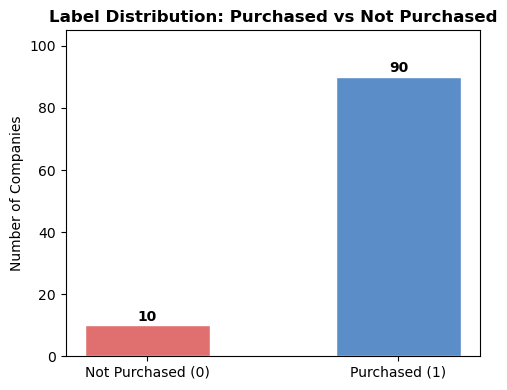

In [11]:
# EDA: Label Balance

fig, ax = plt.subplots(figsize=(5, 4))
counts = all_customers["purchased"].value_counts()
bars = ax.bar(
    ["Not Purchased (0)", "Purchased (1)"],
    [counts[0], counts[1]],
    color=["#e07070", "#5b8dc9"], edgecolor="white", width=0.5
)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            str(int(bar.get_height())),
            ha="center", va="bottom", fontweight="bold")
ax.set_title("Label Distribution: Purchased vs Not Purchased", fontweight="bold")
ax.set_ylabel("Number of Companies")
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

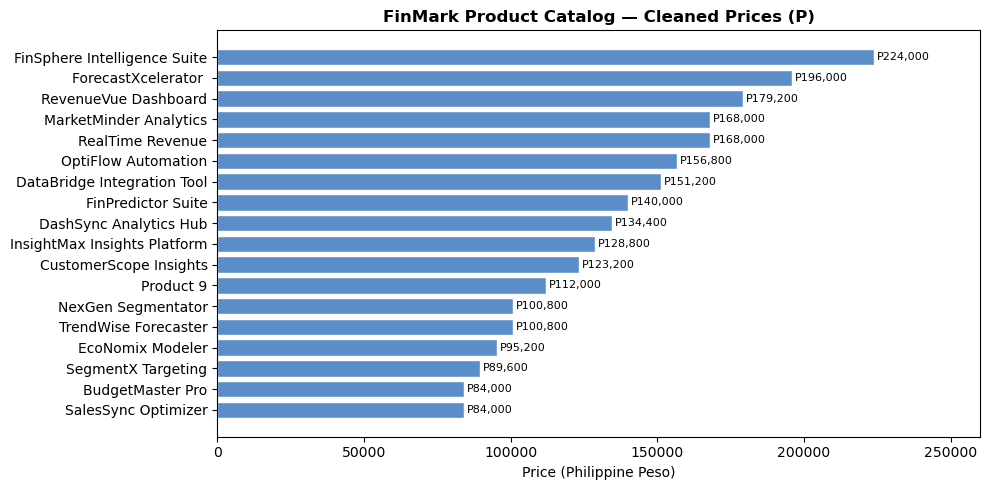

In [12]:
# EDA: Product Catalog Prices 
# A visual look at all 18 products and their cleaned peso prices.

fig, ax = plt.subplots(figsize=(10, 5))
prod_sorted = clean_products.sort_values("Product_Price_PHP")
bars = ax.barh(
    prod_sorted["Product_Name"],
    prod_sorted["Product_Price_PHP"],
    color="#5b8dc9", edgecolor="white"
)
for bar in bars:
    ax.text(bar.get_width() + 1000,
            bar.get_y() + bar.get_height() / 2,
            f"P{bar.get_width():,.0f}",
            va="center", fontsize=8)
ax.set_title("FinMark Product Catalog — Cleaned Prices (P)", fontweight="bold")
ax.set_xlabel("Price (Philippine Peso)")
ax.set_xlim(0, 260000)
plt.tight_layout()
plt.show()

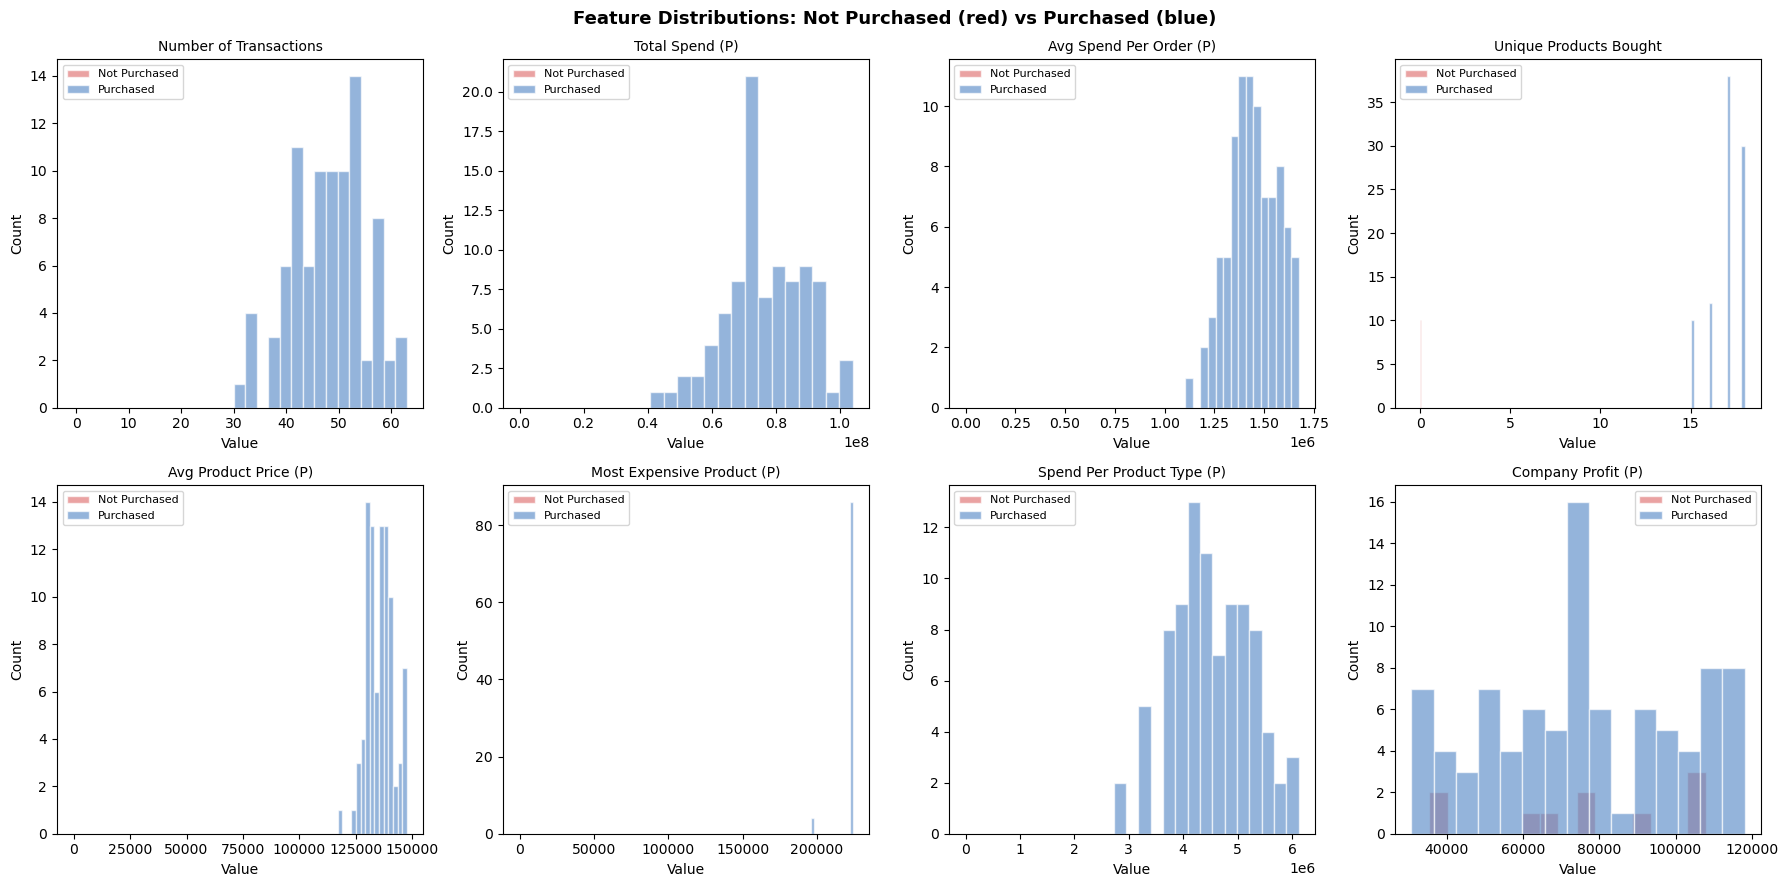

In [13]:
# EDA: Feature Distributions by Label 
# Compare key features between the two groups (0 vs 1).
# If the groups look very different from each other, those features help the model.

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
fig.suptitle("Feature Distributions: Not Purchased (red) vs Purchased (blue)",
             fontsize=13, fontweight="bold")

features_to_plot = [
    ("num_transactions",     "Number of Transactions"),
    ("total_spend",          "Total Spend (P)"),
    ("avg_spend",            "Avg Spend Per Order (P)"),
    ("unique_products",      "Unique Products Bought"),
    ("avg_product_price",    "Avg Product Price (P)"),
    ("max_product_price",    "Most Expensive Product (P)"),
    ("spend_per_product",    "Spend Per Product Type (P)"),
    ("Company_Profit_filled","Company Profit (P)"),
]

for ax, (col, title) in zip(axes.flatten(), features_to_plot):
    for label_val, color, name in [(0, "#e07070", "Not Purchased"),
                                    (1, "#5b8dc9", "Purchased")]:
        group = all_customers[all_customers["purchased"] == label_val][col]
        ax.hist(group, bins=15, alpha=0.65, color=color, label=name, edgecolor="white")
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [14]:
# EDA: Summary Statistics by Label

summary_cols = [
    "num_transactions", "total_spend", "avg_spend",
    "unique_products", "avg_product_price", "Company_Profit_filled", "purchased"
]
summary = all_customers[summary_cols].groupby("purchased").mean().round(2)
summary.index = ["Not Purchased (0)", "Purchased (1)"]

print("Average feature values by label:")
display(summary)

Average feature values by label:


,num_transactions,total_spend,avg_spend,unique_products,avg_product_price,Company_Profit_filled
Not Purchased (0),0.00,0.0,0.00,0.00,0.0,77154.25
Purchased (1),47.99,76805120.0,1443963.77,16.98,135628.7,76170.22


In [15]:
# SELECT FEATURES (X) AND TARGET (y)

feature_columns = [
    # From transactions
    "num_transactions",    # number of orders placed
    "total_quantity",      # total items ordered
    "avg_quantity",        # average items per order
    "total_spend",         # total money spent
    "avg_spend",           # average money per order
    "unique_products",     # number of different products bought
    "spend_per_product",   # total_spend divided by unique_products

    # From products (after cleaning peso prices)
    "avg_product_price",   # average catalog price of products this company buys
    "max_product_price",   # most expensive product this company ever bought
    "min_product_price",   # cheapest product this company ever bought

    # From customers
    "has_profit_info",        # 1 if profit is known, 0 if missing
    "Company_Profit_filled",  # company profit (median used where missing)
]

X = all_customers[feature_columns]   # inputs
y = all_customers["purchased"]        # target

print(f"X shape : {X.shape}  ->  {X.shape[0]} companies x {X.shape[1]} features")
print(f"y shape : {y.shape}")
print()
print("Label counts:")
print(y.value_counts())

X shape : (100, 12)  ->  100 companies x 12 features
y shape : (100,)

Label counts:
purchased
1    90
0    10
Name: count, dtype: int64


In [16]:
# train/test split
# 80 companies → training (model learns from this)
# 20 companies → test (we measure performance on this)
# stratify=y keeps the same 90/10 ratio in both sets
# random_state=42 gives the same split every time you run the code

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train / Test split:")
print(f"  Training : {len(X_train)} companies  (Purchased: {(y_train==1).sum()} | Not: {(y_train==0).sum()})")
print(f"  Test     : {len(X_test)} companies   (Purchased: {(y_test==1).sum()}  | Not: {(y_test==0).sum()})")

Train / Test split:
  Training : 80 companies  (Purchased: 72 | Not: 8)
  Test     : 20 companies   (Purchased: 18  | Not: 2)


In [17]:
# Build and train the model
# Pipeline chains two steps automatically:
#   Step 1: StandardScaler → rescales all numbers to the same range
#           (so total_spend in millions does not overpower has_profit_info which is 0 or 1)
#   Step 2: LogisticRegression → learns to predict 0 or 1 from the scaled features

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    LogisticRegression(max_iter=1000, random_state=42)),
])

# .fit() is where the model actually learns from the training data
model.fit(X_train, y_train)

print("Model trained successfully!")
print(f"  Algorithm     : Logistic Regression")
print(f"  Training rows : {len(X_train)}")
print(f"  Features used : {len(feature_columns)}")

Model trained successfully!
  Algorithm     : Logistic Regression
  Training rows : 80
  Features used : 12


In [18]:
# Evaluate the Moel/ Generate Predictions
# .predict()       -> final decision: 0 or 1 for each company
# .predict_proba() -> probability of each class
# [:, 1]           -> we take the probability of class 1 (purchased)

y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Predictions for each test company:")
print(f"{'#':<4} {'Actual':>8} {'Predicted':>10} {'Probability':>13}  Result")
print("-" * 52)
for i in range(len(y_test)):
    actual    = y_test.iloc[i]
    predicted = y_pred[i]
    prob      = y_proba[i]
    result    = "Correct" if actual == predicted else "WRONG"
    print(f"{i+1:<4} {actual:>8} {predicted:>10} {prob:>13.4f}  {result}")

Predictions for each test company:
#      Actual  Predicted   Probability  Result
----------------------------------------------------
1           1          1        0.9978  Correct
2           1          1        0.9984  Correct
3           1          1        0.9990  Correct
4           1          1        0.9993  Correct
5           1          1        0.9986  Correct
6           1          1        0.9991  Correct
7           1          1        0.9991  Correct
8           1          1        0.9985  Correct
9           1          1        0.9995  Correct
10          0          0        0.0156  Correct
11          1          1        0.9997  Correct
12          1          1        0.9988  Correct
13          1          1        0.9994  Correct
14          1          1        0.9951  Correct
15          0          0        0.0149  Correct
16          1          1        0.9988  Correct
17          1          1        0.9984  Correct
18          1          1        0.9994  Correct
1

In [19]:
# Classification Report
# Precision : Of all predicted '1', how many actually were 1?
# Recall    : Of all actual '1', how many did we correctly find?
# F1-score  : Balance between Precision and Recall (1.0 = perfect)
# Accuracy  : Overall % of correct predictions

print("=" * 55)
print("         CLASSIFICATION REPORT")
print("=" * 55)
print(classification_report(
    y_test, y_pred,
    target_names=["Not Purchased (0)", "Purchased (1)"]
))

# ROC AUC: how well the model separates class 0 from class 1
# 1.0 = perfect | 0.5 = random guessing
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score : {auc:.4f}")
print("(1.0 = perfect | 0.5 = random guessing)")

         CLASSIFICATION REPORT
                   precision    recall  f1-score   support

Not Purchased (0)       1.00      1.00      1.00         2
    Purchased (1)       1.00      1.00      1.00        18

         accuracy                           1.00        20
        macro avg       1.00      1.00      1.00        20
     weighted avg       1.00      1.00      1.00        20

ROC AUC Score : 1.0000
(1.0 = perfect | 0.5 = random guessing)


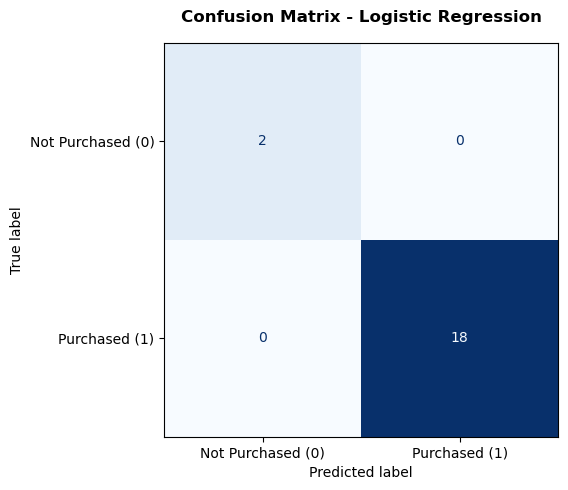

In [20]:
# Confusion MAtrix
# Rows = Actual label | Columns = Predicted label
# Shows how many predictions were correct vs incorrect.

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Not Purchased (0)", "Purchased (1)"],
    ax=ax, colorbar=False, cmap="Blues"
)
ax.set_title("Confusion Matrix - Logistic Regression", fontweight="bold", pad=15)
plt.tight_layout()
plt.show()

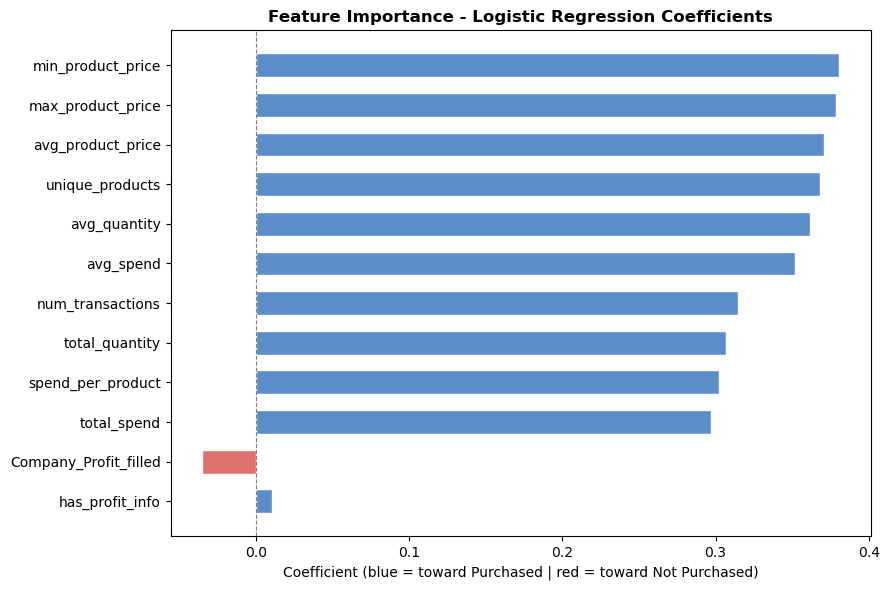


Feature coefficients (most influential first):
              Feature  Coefficient
    min_product_price     0.380342
    max_product_price     0.378323
    avg_product_price     0.370428
      unique_products     0.368267
         avg_quantity     0.361422
            avg_spend     0.351832
     num_transactions     0.314278
       total_quantity     0.307057
    spend_per_product     0.302388
          total_spend     0.297227
Company_Profit_filled    -0.034863
      has_profit_info     0.010751


In [21]:
# Feature Importance
# Logistic Regression gives each feature a coefficient.
# Large positive -> pushes prediction toward 'purchased = 1'
# Large negative -> pushes toward 'purchased = 0'
# Near zero      -> little influence on the prediction

lr_step = model.named_steps["clf"]

importance_df = pd.DataFrame({
    "Feature"     : feature_columns,
    "Coefficient" : lr_step.coef_[0],
}).sort_values("Coefficient", key=abs, ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
colors = ["#5b8dc9" if c >= 0 else "#e07070" for c in importance_df["Coefficient"]]
ax.barh(importance_df["Feature"], importance_df["Coefficient"],
        color=colors, edgecolor="white", height=0.6)
ax.axvline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.5)
ax.set_title("Feature Importance - Logistic Regression Coefficients", fontweight="bold")
ax.set_xlabel("Coefficient (blue = toward Purchased | red = toward Not Purchased)")
plt.tight_layout()
plt.show()

print("\nFeature coefficients (most influential first):")
print(
    importance_df.sort_values("Coefficient", key=abs, ascending=False)
    .to_string(index=False)
)

In [22]:
# Score All 100 Customers
# Apply the trained model to all 100 companies to generate a
# purchase likelihood score (a probability from 0.0 to 1.0).

all_customers["purchase_likelihood"] = model.predict_proba(X)[:, 1].round(4)

# Top 10 most likely
print("Top 10 Companies MOST Likely to Purchase:")
display(
    all_customers.nlargest(10, "purchase_likelihood")[
        ["Company_Name", "num_transactions", "total_spend",
         "avg_product_price", "purchased", "purchase_likelihood"]
    ].reset_index(drop=True)
)

print()
print("Bottom 10 Companies LEAST Likely to Purchase:")
display(
    all_customers.nsmallest(10, "purchase_likelihood")[
        ["Company_Name", "num_transactions", "total_spend",
         "avg_product_price", "purchased", "purchase_likelihood"]
    ].reset_index(drop=True)
)

Top 10 Companies MOST Likely to Purchase:


,Company_Name,num_transactions,total_spend,avg_product_price,purchased,purchase_likelihood
0,Innovative Solutions 68,57.0,104042400.0,135887.500000,1,0.9997
1,Global Solutions 89,61.0,103544000.0,140430.769231,1,0.9997
2,Quantum Enterprises 13,63.0,101248000.0,139211.267606,1,0.9996
3,Tech Ventures 76,59.0,95026400.0,137651.612903,1,0.9996
4,Global Enterprises 9,52.0,92556800.0,132565.517241,1,0.9995
5,Dynamic Solutions 17,57.0,93167200.0,136116.129032,1,0.9995
6,Tech Holdings 49,57.0,94136000.0,135706.666667,1,0.9995
7,Tech Associates 65,50.0,92909600.0,145800.000000,1,0.9995
8,Quantum Associates 67,61.0,99618400.0,136529.577465,1,0.9995
9,Innovative Partners 78,54.0,90994400.0,137200.000000,1,0.9995



Bottom 10 Companies LEAST Likely to Purchase:


,Company_Name,num_transactions,total_spend,avg_product_price,purchased,purchase_likelihood
0,Green Enterprises 8,0.0,0.0,0.0,0,0.0141
1,Pioneer Network 36,0.0,0.0,0.0,0,0.0141
2,Elite Corp 99,0.0,0.0,0.0,0,0.0141
3,Quantum Solutions 74,0.0,0.0,0.0,0,0.0143
4,Innovative Industries 52,0.0,0.0,0.0,0,0.0144
5,Quantum Holdings 14,0.0,0.0,0.0,0,0.0147
6,Sky Network 18,0.0,0.0,0.0,0,0.0149
7,Global Holdings 28,0.0,0.0,0.0,0,0.0150
8,Elite Network 6,0.0,0.0,0.0,0,0.0155
9,Innovative Holdings 40,0.0,0.0,0.0,0,0.0156


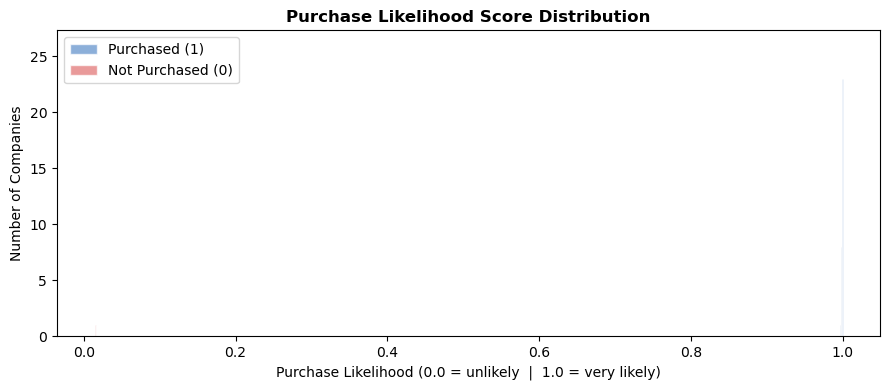

In [23]:
# purchase likelihood

fig, ax = plt.subplots(figsize=(9, 4))
for label_val, color, name in [(1, "#5b8dc9", "Purchased (1)"),
                                (0, "#e07070", "Not Purchased (0)")]:
    group = all_customers[all_customers["purchased"] == label_val]["purchase_likelihood"]
    ax.hist(group, bins=20, alpha=0.7, color=color, label=name, edgecolor="white")
ax.set_title("Purchase Likelihood Score Distribution", fontweight="bold")
ax.set_xlabel("Purchase Likelihood (0.0 = unlikely  |  1.0 = very likely)")
ax.set_ylabel("Number of Companies")
ax.legend()
plt.tight_layout()
plt.show()

In [24]:
# Save outputs

os.makedirs("milestone1_output", exist_ok=True)

# 1. Full scored customer table (use this in Milestone 2)
all_customers.to_csv("milestone1_output/customer_purchase_likelihood.csv", index=False)

# 2. Clean products with properly cleaned peso prices
clean_products[["Product_ID", "Product_Name", "Product_Price_PHP"]].to_csv(
    "milestone1_output/clean_products_with_price.csv", index=False
)

print("Files saved to milestone1_output/ folder:")
print(f"  1. customer_purchase_likelihood.csv  -> {len(all_customers)} companies with scores")
print(f"  2. clean_products_with_price.csv     -> {len(clean_products)} products with cleaned prices")

Files saved to milestone1_output/ folder:
  1. customer_purchase_likelihood.csv  -> 100 companies with scores
  2. clean_products_with_price.csv     -> 18 products with cleaned prices
